In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

display.set_matplotlib_formats('svg')

/tmp/ipython-input-4172365778.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Data

In [27]:
import seaborn as sns

iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [28]:
data = torch.tensor(iris.iloc[:,:4].values).float()
data[:5,:]

tensor([[5.1000, 3.5000, 1.4000, 0.2000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [4.7000, 3.2000, 1.3000, 0.2000],
        [4.6000, 3.1000, 1.5000, 0.2000],
        [5.0000, 3.6000, 1.4000, 0.2000]])

In [29]:
labels = torch.zeros(data.shape[0], dtype = torch.long)
labels[iris.species == 'setosa'] = 0
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

# Simple Model

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ANN(nn.Module):
  def __init__(self, nUnits, nLayers):
    super().__init__()
    self.nLayers = nLayers

    self.layers = nn.ModuleDict()

    self.layers['input'] = nn.Linear(4, nUnits)

    for i in range(nLayers):
      self.layers[f'hidden_{i}'] = nn.Linear(nUnits, nUnits)

    self.layers['output'] = nn.Linear(nUnits, 3)

  def forward(self, x):
    x = self.layers['input'](x)

    for i in range(self.nLayers):
      x = F.relu(self.layers[f'hidden_{i}'](x))

    x = self.layers['output'](x)

    return x

ann = ANN(nUnits=32, nLayers=8)
ann

ANN(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=32, bias=True)
    (hidden_0): Linear(in_features=32, out_features=32, bias=True)
    (hidden_1): Linear(in_features=32, out_features=32, bias=True)
    (hidden_2): Linear(in_features=32, out_features=32, bias=True)
    (hidden_3): Linear(in_features=32, out_features=32, bias=True)
    (hidden_4): Linear(in_features=32, out_features=32, bias=True)
    (hidden_5): Linear(in_features=32, out_features=32, bias=True)
    (hidden_6): Linear(in_features=32, out_features=32, bias=True)
    (hidden_7): Linear(in_features=32, out_features=32, bias=True)
    (output): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [31]:
tmp_x = torch.randn(10, 4)

y = ann(tmp_x)

print(y.shape, y)

torch.Size([10, 3]) tensor([[ 0.0844, -0.0207,  0.0409],
        [ 0.0843, -0.0198,  0.0409],
        [ 0.0845, -0.0203,  0.0407],
        [ 0.0844, -0.0200,  0.0407],
        [ 0.0844, -0.0206,  0.0406],
        [ 0.0844, -0.0208,  0.0411],
        [ 0.0843, -0.0199,  0.0406],
        [ 0.0844, -0.0202,  0.0407],
        [ 0.0844, -0.0204,  0.0408],
        [ 0.0844, -0.0208,  0.0406]], grad_fn=<AddmmBackward0>)


# Train

In [32]:
def train(Model, data, labels, epochs):
  # Model.train()

  lossfn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(Model.parameters(), lr=1e-3)

  for epoch in range(epochs):
    yHat = Model(data)

    loss = lossfn(yHat, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%10==0:
      print(f'Epoch: {epoch}, Loss: {loss}')

  # Model.eval()
  with torch.no_grad():
    preds = Model(data)
    predlabels = torch.argmax(preds, axis=1)
    acc = 100*torch.mean((predlabels == labels).float())
  nParams = sum(p.numel() for p in Model.parameters() if p.requires_grad)

  return acc, nParams

train(ann, data, labels, epochs=1000)

Epoch: 0, Loss: 1.0995161533355713
Epoch: 10, Loss: 1.0954049825668335
Epoch: 20, Loss: 1.0777784585952759
Epoch: 30, Loss: 1.0257973670959473
Epoch: 40, Loss: 0.8971375823020935
Epoch: 50, Loss: 0.5829152464866638
Epoch: 60, Loss: 0.331510990858078
Epoch: 70, Loss: 0.09948793798685074
Epoch: 80, Loss: 0.06508999317884445
Epoch: 90, Loss: 0.060540974140167236
Epoch: 100, Loss: 0.06021702289581299
Epoch: 110, Loss: 0.05861134082078934
Epoch: 120, Loss: 0.05791953578591347
Epoch: 130, Loss: 0.05682794004678726
Epoch: 140, Loss: 0.0575307197868824
Epoch: 150, Loss: 0.056223250925540924
Epoch: 160, Loss: 0.054922159761190414
Epoch: 170, Loss: 0.05405227094888687
Epoch: 180, Loss: 0.0534406416118145
Epoch: 190, Loss: 0.05334141477942467
Epoch: 200, Loss: 0.05287923663854599
Epoch: 210, Loss: 0.05176609009504318
Epoch: 220, Loss: 0.0520835816860199
Epoch: 230, Loss: 0.051008693873882294
Epoch: 240, Loss: 0.05045967176556587
Epoch: 250, Loss: 0.05067401006817818
Epoch: 260, Loss: 0.0498432591

(tensor(98.6667), 8707)

# Experiment

In [33]:
numlayers = range(1,6)
numunits = np.arange(4,101,3) # units per hidden layer

# initialize output matrices
accuracies = np.zeros((len(numunits), len(numlayers)))
totalparams = np.zeros((len(numunits), len(numlayers)))

numepochs = 500

for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    net = ANN(numunits[unitidx], numlayers[layeridx])

    acc, nParams = train(net, data = data, labels = labels, epochs = numepochs)

    accuracies[unitidx, layeridx] = acc

    totalparams[unitidx, layeridx] = nParams

  print(f'Done layer {layeridx}')

Streaming output truncated to the last 5000 lines.
Epoch: 200, Loss: 0.07903135567903519
Epoch: 210, Loss: 0.075792595744133
Epoch: 220, Loss: 0.07305040955543518
Epoch: 230, Loss: 0.07070297747850418
Epoch: 240, Loss: 0.06867258995771408
Epoch: 250, Loss: 0.06690046936273575
Epoch: 260, Loss: 0.06533960998058319
Epoch: 270, Loss: 0.06395446509122849
Epoch: 280, Loss: 0.06271658837795258
Epoch: 290, Loss: 0.06160304322838783
Epoch: 300, Loss: 0.06059528887271881
Epoch: 310, Loss: 0.05967826768755913
Epoch: 320, Loss: 0.05883980542421341
Epoch: 330, Loss: 0.05806919187307358
Epoch: 340, Loss: 0.05735819414258003
Epoch: 350, Loss: 0.05669922009110451
Epoch: 360, Loss: 0.056085873395204544
Epoch: 370, Loss: 0.05551254749298096
Epoch: 380, Loss: 0.05497469753026962
Epoch: 390, Loss: 0.054468389600515366
Epoch: 400, Loss: 0.05399022251367569
Epoch: 410, Loss: 0.053537312895059586
Epoch: 420, Loss: 0.053107015788555145
Epoch: 430, Loss: 0.052697308361530304
Epoch: 440, Loss: 0.05230610817670

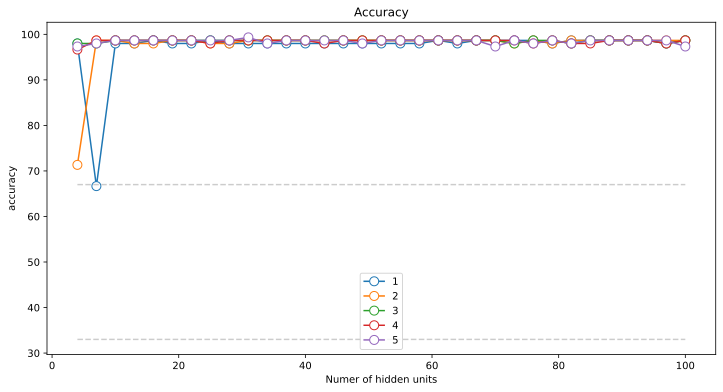

In [34]:
fig, ax = plt.subplots(1, figsize=(12, 6))

ax.plot(numunits, accuracies, 'o-', markerfacecolor='w', markersize=9)
ax.plot(numunits[[0,-1]], [33,33], '--', color=[.8,.8,.8])
ax.plot(numunits[[0,-1]], [67,67], '--', color=[.8,.8,.8])
ax.legend(numlayers)
ax.set_ylabel('accuracy')
ax.set_xlabel('Numer of hidden units')
ax.set_title('Accuracy')
plt.show()

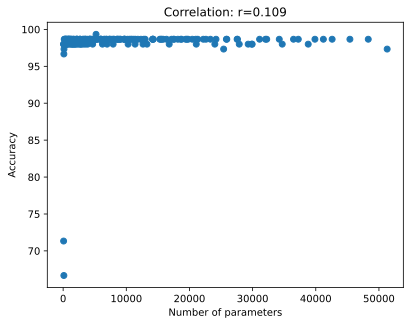

In [35]:
x = totalparams.flatten()
y = accuracies.flatten()

r = np.corrcoef(x,y)[0,1]

plt.plot(x,y,'o')
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy')
plt.title('Correlation: r=' + str(np.round(r,3)))
plt.show()